### 13 Jan 2023

# Fig. 6 code

NOTE: Apologies for repetition in this script :).

In [157]:
# load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 2014

### 1. Read seal data (this time previsouly subsetted dataframe created at the end of fig.4 notebook)
This is just to save time, but we can also go through all the steps again similar to fig.4 and 5 scripts combined.

In [127]:
# read data
meltwater14array = pd.read_pickle('meltwater14array_file')
meltwater14array.head()

,CT,SA,z,Datetime,LATITUDE,LONGITUDE,Station,Meltwater_frac
0,-1.853862,34.045220,0.000000,2014-05-01 01:20:00.000038400,-74.875096,-102.555068,ct104-EF838-13_prof 1,15.839480
1,-1.853879,34.045198,0.989617,2014-05-01 01:20:00.000038400,-74.875096,-102.555068,ct104-EF838-13_prof 1,15.840580
2,-1.853895,34.045176,1.979229,2014-05-01 01:20:00.000038400,-74.875096,-102.555068,ct104-EF838-13_prof 1,15.841680
3,-1.853908,34.045437,2.968837,2014-05-01 01:20:00.000038400,-74.875096,-102.555068,ct104-EF838-13_prof 1,15.826554
4,-1.853916,34.045702,3.958439,2014-05-01 01:20:00.000038400,-74.875096,-102.555068,ct104-EF838-13_prof 1,15.811268


### 2. Partition by month

In [128]:
meltmay14 = meltwater14array[(meltwater14array['Datetime']>='2014-05-01') & (meltwater14array['Datetime']<'2014-06-1')] 
meltjune14 = meltwater14array[(meltwater14array['Datetime']>='2014-06-01') & (meltwater14array['Datetime']<'2014-07-1')] 
meltjuly14 = meltwater14array[(meltwater14array['Datetime']>='2014-07-01') & (meltwater14array['Datetime']<'2014-08-1')] 
meltaug14 = meltwater14array[(meltwater14array['Datetime']>'2014-08-01') & (meltwater14array['Datetime']<'2014-09-1')] 

### 3. Separate warm and cool/background profiles based on cutoff temp from step 2 and apply smoothing filter.
Lots of steps here, but essentially we are not doing much, just prepping the data for seperation of warm and cool dives for plotting.

In [129]:
# T cutoff thresh (defined in fig. 5 script)
seal14 = pd.read_pickle('seal14_file')

# define cool ("background") dives in dataframe within bounding box lat/lon
coolsurf = seal14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-74.9 < LATITUDE < -74 & -104.7 < LONGITUDE < -102 & 0.0 <= z <= 20')
coolsurfMJJA14 = coolsurf[(coolsurf['Datetime']>='2014-5-1') & (coolsurf['Datetime']<'2014-9-1')] # constrain winter months

# calculate temperature treshold at 3std > background surface mean
thresh2014 = coolsurfMJJA14['CT'].mean() + 3*coolsurfMJJA14['CT'].std()

# Cutoff T in deg C
print('2014 threshold:',thresh2014) #CT

2014 threshold: -1.5401140979068026


#### May 2014

In [130]:
# isolate may14 data
may14surf = meltmay14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
may14surf = may14surf.reset_index()

# round lat,lon
may14surf['LAT_rounded'] = round(may14surf.iloc[:,3],4)
may14surf['LONG_rounded'] = round(may14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
may14surf = may14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
may14surf = may14surf.reset_index()

# isolate warm profiles based on thresh
may14surfwarm = may14surf[may14surf.iloc[:,5] > thresh2014] 
may14surfcool = may14surf[may14surf.iloc[:,5] < thresh2014] 

# add rounded lat long to meltwater14array so that we have same header and vals
meltwater14array['LAT_rounded'] = round(meltwater14array.iloc[:,4],4)
meltwater14array['LONG_rounded'] = round(meltwater14array.iloc[:,5],4)
#seal19.head()

# isolate warm profiles w entire depth information - replace seal14 w meltwater14array b/c this one has meltwater in it
may14w = meltwater14array[meltwater14array['LAT_rounded'].isin(may14surfwarm['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(may14surfwarm['LONG_rounded'])]
may14c = meltwater14array[meltwater14array['LAT_rounded'].isin(may14surfcool['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(may14surfcool['LONG_rounded'])]
#may19w.count()

# probs need to round z first: warm
may14w['z_rounded'] = round(may14w.iloc[:,2])
may14w.head()
may14w_test = may14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
may14c['z_rounded'] = round(may14c.iloc[:,2])
may14c.head()
may14c_test = may14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_may14c = may14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may14w = may14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_may14cSA = may14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may14wSA = may14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# Melt
smooth_may14cmelt = may14c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may14wmelt = may14w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/2377490140.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may14c['z_rounded'] = round(may14c.iloc[:,2])


#### June 2014

In [131]:
# isolate may14 data
june14surf = meltjune14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
june14surf = june14surf.reset_index()

# round lat,lon
june14surf['LAT_rounded'] = round(june14surf.iloc[:,3],4)
june14surf['LONG_rounded'] = round(june14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
june14surf = june14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
june14surf = june14surf.reset_index()

# isolate warm profiles based on thresh
june14surfwarm = june14surf[june14surf.iloc[:,5] > thresh2014] 
june14surfcool = june14surf[june14surf.iloc[:,5] < thresh2014] 

# add rounded lat long to meltwater14array so that we have same header and vals
meltwater14array['LAT_rounded'] = round(meltwater14array.iloc[:,4],4)
meltwater14array['LONG_rounded'] = round(meltwater14array.iloc[:,5],4)

# isolate warm profiles w entire depth information - replace seal14 w meltwater14array b/c this one has meltwater in it
june14w = meltwater14array[meltwater14array['LAT_rounded'].isin(june14surfwarm['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(june14surfwarm['LONG_rounded'])]
june14c = meltwater14array[meltwater14array['LAT_rounded'].isin(june14surfcool['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(june14surfcool['LONG_rounded'])]

# probs need to round z first: warm
june14w['z_rounded'] = round(june14w.iloc[:,2])
june14w_test = june14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
june14c['z_rounded'] = round(june14c.iloc[:,2])
june14c_test = june14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_june14c = june14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june14w = june14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_june14cSA = june14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june14wSA = june14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_june14cmelt = june14c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june14wmelt = june14w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/3518480987.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june14w['z_rounded'] = round(june14w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/3518480987.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june14c['z_rounded'] = round(june14c.iloc[:,2])


#### Extra: here there is one dive outlier where MW does not make sense, so remove that single dive
Comment these next two cells out and plot to see what I mean (unphysical horizontal blue line appears on panel--this is what we are removing here: one single dive in the entire month).

In [132]:
# find dive at where outlier
june14c[june14c['Meltwater_frac']>20].head()

,CT,SA,z,Datetime,LATITUDE,LONGITUDE,Station,Meltwater_frac,LAT_rounded,LONG_rounded,z_rounded
106176,-1.852003,32.218603,0.000000,2014-06-12 10:25:00.000019200,-74.96211,-103.608893,ct104-WF858-13_prof 1,120.708785,-74.9621,-103.6089,0.0
106177,-1.852015,32.218587,0.989613,2014-06-12 10:25:00.000019200,-74.96211,-103.608893,ct104-WF858-13_prof 1,120.709582,-74.9621,-103.6089,1.0
106178,-1.852028,32.218571,1.979221,2014-06-12 10:25:00.000019200,-74.96211,-103.608893,ct104-WF858-13_prof 1,120.710378,-74.9621,-103.6089,2.0
106179,-1.851871,32.218603,2.968825,2014-06-12 10:25:00.000019200,-74.96211,-103.608893,ct104-WF858-13_prof 1,120.710250,-74.9621,-103.6089,3.0
106180,-1.851419,32.218730,3.958423,2014-06-12 10:25:00.000019200,-74.96211,-103.608893,ct104-WF858-13_prof 1,120.707865,-74.9621,-103.6089,4.0


In [133]:
# drop all rows associated w single dive (at lat -74.9621) where melt vals unreasonably high
test = june14c.drop(june14c[june14c.LAT_rounded == -74.9621].index)
june14c = test

#june14c.count()

#### July 2014

In [134]:
# isolate jul14 data
july14surf = meltjuly14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
july14surf = july14surf.reset_index()

# round lat,lon
july14surf['LAT_rounded'] = round(july14surf.iloc[:,3],4)
july14surf['LONG_rounded'] = round(july14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
july14surf = july14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
july14surf = july14surf.reset_index()

# isolate warm profiles based on thresh
july14surfwarm = july14surf[july14surf.iloc[:,5] > thresh2014] 
july14surfcool = july14surf[july14surf.iloc[:,5] < thresh2014] 

# add rounded lat long to meltwater14array so that we have same header and vals
meltwater14array['LAT_rounded'] = round(meltwater14array.iloc[:,4],4)
meltwater14array['LONG_rounded'] = round(meltwater14array.iloc[:,5],4)

# isolate warm profiles w entire depth information - replace seal14 w meltwater14array b/c this one has meltwater in it
july14w = meltwater14array[meltwater14array['LAT_rounded'].isin(july14surfwarm['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(july14surfwarm['LONG_rounded'])]
july14c = meltwater14array[meltwater14array['LAT_rounded'].isin(july14surfcool['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(july14surfcool['LONG_rounded'])]

# probs need to round z first: warm
july14w['z_rounded'] = round(july14w.iloc[:,2])
july14w_test = july14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
july14c['z_rounded'] = round(july14c.iloc[:,2])
july14c_test = july14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_july14c = july14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july14w = july14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_july14cSA = july14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july14wSA = july14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_july14cmelt = july14c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july14wmelt = july14w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/1571063692.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july14w['z_rounded'] = round(july14w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/1571063692.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july14c['z_rounded'] = round(july14c.iloc[:,2])


#### Extra: here there is one dive outlier where MW does not make sense, so remove that single dive
Again here, we are removing a single out. Comment out two next cells and plot to see what I mean. 

In [135]:
# find dive where outlier
test = july14c[july14c['Meltwater_frac']>20]
test = test[test['z']==0]
test

,CT,SA,z,Datetime,LATITUDE,LONGITUDE,Station,Meltwater_frac,LAT_rounded,LONG_rounded,z_rounded
172866,-1.843506,32.783442,0.0,2014-07-12 17:01:59.999980800,-74.669844,-101.635436,ct104-WF858-13_prof 1,88.37931,-74.6698,-101.6354,0.0


In [136]:
# drop all rows associated w single dive (at lat -74.9621) where melt vals unreasonably high
test2 = july14c.drop(july14c[july14c.LAT_rounded == -74.6698].index)
july14c = test2

## August 2014

In [137]:
# isolate may14 data
aug14surf = meltaug14[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
aug14surf = aug14surf.reset_index()

# round lat,lon
aug14surf['LAT_rounded'] = round(aug14surf.iloc[:,3],4)
aug14surf['LONG_rounded'] = round(aug14surf.iloc[:,4],4)

# Groubpy (on rounded cols)
aug14surf = aug14surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
aug14surf = aug14surf.reset_index()

# isolate warm profiles based on thresh
aug14surfwarm = aug14surf[aug14surf.iloc[:,5] > thresh2014] 
aug14surfcool = aug14surf[aug14surf.iloc[:,5] < thresh2014] 

# add rounded lat long to meltwater14array so that we have same header and vals
meltwater14array['LAT_rounded'] = round(meltwater14array.iloc[:,4],4)
meltwater14array['LONG_rounded'] = round(meltwater14array.iloc[:,5],4)
#seal19.head()

# isolate warm profiles w entire depth information - replace seal14 w meltwater14array b/c this one has meltwater in it
aug14w = meltwater14array[meltwater14array['LAT_rounded'].isin(aug14surfwarm['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(aug14surfwarm['LONG_rounded'])]
aug14c = meltwater14array[meltwater14array['LAT_rounded'].isin(aug14surfcool['LAT_rounded']) & meltwater14array['LONG_rounded'].isin(aug14surfcool['LONG_rounded'])]
#aug19w.count()

# probs need to round z first: warm
aug14w['z_rounded'] = round(aug14w.iloc[:,2])
aug14w.head()
aug14w_test = aug14w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
aug14c['z_rounded'] = round(aug14c.iloc[:,2])
aug14c.head()
aug14c_test = aug14c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_aug14c = aug14c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug14w = aug14w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_aug14cSA = aug14c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug14wSA = aug14w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_aug14cmelt = aug14c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug14wmelt = aug14w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/1475164089.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug14w['z_rounded'] = round(aug14w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/1475164089.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug14c['z_rounded'] = round(aug14c.iloc[:,2])


### 5. Reset dataframe index and plot profiles!

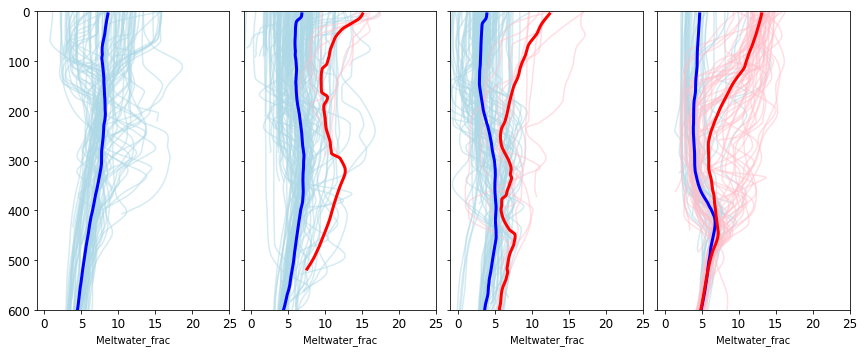

In [139]:
# need to set index to CT to plot CT
may14c.reset_index(inplace=True)
may14w.reset_index(inplace=True)
may14c.set_index('Meltwater_frac', inplace=True)
may14w.set_index('Meltwater_frac', inplace=True)

june14c.reset_index(inplace=True)
june14w.reset_index(inplace=True)
june14c.set_index('Meltwater_frac', inplace=True)
june14w.set_index('Meltwater_frac', inplace=True)

july14c.reset_index(inplace=True)
july14w.reset_index(inplace=True)
july14c.set_index('Meltwater_frac', inplace=True)
july14w.set_index('Meltwater_frac', inplace=True)

aug14c.reset_index(inplace=True)
aug14w.reset_index(inplace=True)
aug14c.set_index('Meltwater_frac', inplace=True)
aug14w.set_index('Meltwater_frac', inplace=True)

# plot
plt.figure(figsize=(12,5))
plt.rcParams['axes.facecolor']='w'
# # CT
plt.subplot(141)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
may14c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
may14w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_may14cmelt, may14c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_may14wmelt, may14w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)

#plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
#
plt.subplot(142)
plt.xticks(fontsize=12)
june14c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
june14w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_june14cmelt, june14c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_june14wmelt, june14w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  
#
plt.subplot(143)
plt.xticks(fontsize=12)
july14c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
july14w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_july14cmelt, july14c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_july14wmelt, july14w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  
#
plt.subplot(144)
plt.xticks(fontsize=12)
aug14c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
aug14w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_aug14cmelt, aug14c_test.z_rounded['mean'], c='b',linewidth=3, label = 'mean cool')
plt.plot(smooth_aug14wmelt, aug14w_test.z_rounded['mean'], c='r',linewidth=3, label = 'mean warm')
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  

plt.tight_layout()

# plt.savefig('fig6_2014_updated.jpg', format='jpg', dpi=400)

## 2019

### 1. Read seal data (this time previsouly subsetted dataframe created at the end of fig.4 notebook)
This is just to save time, but we can also go through all the steps again similar to fig.4 and 5 scripts combined.

In [140]:
# read data
meltwater19array = pd.read_pickle('meltwater19array_file')
meltwater19array.head()

,CT,SA,z,Datetime,LATITUDE,LONGITUDE,Station,Meltwater_frac
0,-1.846025,33.995716,0.000000,2019-05-27 17:39:59.999990400,-74.527204,-103.375288,ct147-894-18_prof,17.607354
1,-1.846041,33.995699,0.989633,2019-05-27 17:39:59.999990400,-74.527204,-103.375288,ct147-894-18_prof,17.608433
2,-1.846057,33.995681,1.979262,2019-05-27 17:39:59.999990400,-74.527204,-103.375288,ct147-894-18_prof,17.609513
3,-1.846074,33.995664,2.968885,2019-05-27 17:39:59.999990400,-74.527204,-103.375288,ct147-894-18_prof,17.610592
4,-1.846090,33.995647,3.958504,2019-05-27 17:39:59.999990400,-74.527204,-103.375288,ct147-894-18_prof,17.611662


### 2. Partition by month

In [141]:
meltmay19 = meltwater19array[(meltwater19array['Datetime']>='2019-05-01') & (meltwater19array['Datetime']<'2019-06-1')] 
meltjune19 = meltwater19array[(meltwater19array['Datetime']>='2019-06-01') & (meltwater19array['Datetime']<'2019-07-1')] 
meltjuly19 = meltwater19array[(meltwater19array['Datetime']>='2019-07-01') & (meltwater19array['Datetime']<'2019-08-1')] 
meltaug19 = meltwater19array[(meltwater19array['Datetime']>'2019-08-01') & (meltwater19array['Datetime']<'2019-09-1')] 

### 3. Separate warm and cool/background profiles based on cutoff temp from step 2 and apply smoothing filter.
Lots of steps here, but essentially we are not doing much, just prepping the data for seperation of warm and cool dives for plotting.

In [142]:
# T cutoff thresh (defined in fig. 5 script)
seal19 = pd.read_pickle('seal19_file')

# define cool ("background") dives in dataframe within bounding box lat/lon
coolsurf = seal19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-74.9 < LATITUDE < -74 & -104.7 < LONGITUDE < -102 & 0.0 <= z <= 20')
coolsurfMJJA19 = coolsurf[(coolsurf['Datetime']>='2019-5-1') & (coolsurf['Datetime']<'2019-9-1')] # constrain winter months

# calculate temperature treshold at 3std > background surface mean
thresh2019 = coolsurfMJJA19['CT'].mean() + 3*coolsurfMJJA19['CT'].std()

# Cutoff T in deg C
print('2019 threshold:',thresh2019) #CT

2019 threshold: -1.685284795066211


#### May 2019

In [143]:
# isolate may19 data
may19surf = meltmay19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
may19surf = may19surf.reset_index()

# round lat,lon
may19surf['LAT_rounded'] = round(may19surf.iloc[:,3],4)
may19surf['LONG_rounded'] = round(may19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
may19surf = may19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
may19surf = may19surf.reset_index()

# isolate warm profiles based on thresh
may19surfwarm = may19surf[may19surf.iloc[:,5] > thresh2019] 
may19surfcool = may19surf[may19surf.iloc[:,5] < thresh2019] 

# add rounded lat long to meltwater19array so that we have same header and vals
meltwater19array['LAT_rounded'] = round(meltwater19array.iloc[:,4],4)
meltwater19array['LONG_rounded'] = round(meltwater19array.iloc[:,5],4)
#seal19.head()

# isolate warm profiles w entire depth information - replace seal19 w meltwater19array b/c this one has meltwater in it
may19w = meltwater19array[meltwater19array['LAT_rounded'].isin(may19surfwarm['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(may19surfwarm['LONG_rounded'])]
may19c = meltwater19array[meltwater19array['LAT_rounded'].isin(may19surfcool['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(may19surfcool['LONG_rounded'])]
#may19w.count()

# probs need to round z first: warm
may19w['z_rounded'] = round(may19w.iloc[:,2])
may19w.head()
may19w_test = may19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
may19c['z_rounded'] = round(may19c.iloc[:,2])
may19c.head()
may19c_test = may19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_may19c = may19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may19w = may19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_may19cSA = may19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may19wSA = may19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# Melt
smooth_may19cmelt = may19c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may19wmelt = may19w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/66090938.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may19w['z_rounded'] = round(may19w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/66090938.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may19c['z_rounded'] = round(may19c.iloc[:,2])


#### June 2019

In [144]:
# isolate may19 data
june19surf = meltjune19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
june19surf = june19surf.reset_index()

# round lat,lon
june19surf['LAT_rounded'] = round(june19surf.iloc[:,3],4)
june19surf['LONG_rounded'] = round(june19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
june19surf = june19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
june19surf = june19surf.reset_index()

# isolate warm profiles based on thresh
june19surfwarm = june19surf[june19surf.iloc[:,5] > thresh2019] 
june19surfcool = june19surf[june19surf.iloc[:,5] < thresh2019] 

# add rounded lat long to meltwater19array so that we have same header and vals
meltwater19array['LAT_rounded'] = round(meltwater19array.iloc[:,4],4)
meltwater19array['LONG_rounded'] = round(meltwater19array.iloc[:,5],4)

# isolate warm profiles w entire depth information - replace seal19 w meltwater19array b/c this one has meltwater in it
june19w = meltwater19array[meltwater19array['LAT_rounded'].isin(june19surfwarm['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(june19surfwarm['LONG_rounded'])]
june19c = meltwater19array[meltwater19array['LAT_rounded'].isin(june19surfcool['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(june19surfcool['LONG_rounded'])]

# probs need to round z first: warm
june19w['z_rounded'] = round(june19w.iloc[:,2])
june19w_test = june19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
june19c['z_rounded'] = round(june19c.iloc[:,2])
june19c_test = june19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_june19c = june19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june19w = june19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_june19cSA = june19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june19wSA = june19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_june19cmelt = june19c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june19wmelt = june19w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/2956733211.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june19w['z_rounded'] = round(june19w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/2956733211.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june19c['z_rounded'] = round(june19c.iloc[:,2])


#### July 2019

In [145]:
# isolate jul19 data
july19surf = meltjuly19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
july19surf = july19surf.reset_index()

# round lat,lon
july19surf['LAT_rounded'] = round(july19surf.iloc[:,3],4)
july19surf['LONG_rounded'] = round(july19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
july19surf = july19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
july19surf = july19surf.reset_index()

# isolate warm profiles based on thresh
july19surfwarm = july19surf[july19surf.iloc[:,5] > thresh2019] 
july19surfcool = july19surf[july19surf.iloc[:,5] < thresh2019] 

# add rounded lat long to meltwater19array so that we have same header and vals
meltwater19array['LAT_rounded'] = round(meltwater19array.iloc[:,4],4)
meltwater19array['LONG_rounded'] = round(meltwater19array.iloc[:,5],4)

# isolate warm profiles w entire depth information - replace seal19 w meltwater19array b/c this one has meltwater in it
july19w = meltwater19array[meltwater19array['LAT_rounded'].isin(july19surfwarm['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(july19surfwarm['LONG_rounded'])]
july19c = meltwater19array[meltwater19array['LAT_rounded'].isin(july19surfcool['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(july19surfcool['LONG_rounded'])]

# probs need to round z first: warm
july19w['z_rounded'] = round(july19w.iloc[:,2])
july19w_test = july19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
july19c['z_rounded'] = round(july19c.iloc[:,2])
july19c_test = july19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_july19c = july19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july19w = july19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_july19cSA = july19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july19wSA = july19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_july19cmelt = july19c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july19wmelt = july19w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/2575381767.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july19w['z_rounded'] = round(july19w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/2575381767.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july19c['z_rounded'] = round(july19c.iloc[:,2])


#### August 2019

In [146]:
# isolate may19 data
aug19surf = meltaug19[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
aug19surf = aug19surf.reset_index()

# round lat,lon
aug19surf['LAT_rounded'] = round(aug19surf.iloc[:,3],4)
aug19surf['LONG_rounded'] = round(aug19surf.iloc[:,4],4)

# Groubpy (on rounded cols)
aug19surf = aug19surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
aug19surf = aug19surf.reset_index()

# isolate warm profiles based on thresh
aug19surfwarm = aug19surf[aug19surf.iloc[:,5] > thresh2019] 
aug19surfcool = aug19surf[aug19surf.iloc[:,5] < thresh2019] 

# add rounded lat long to meltwater19array so that we have same header and vals
meltwater19array['LAT_rounded'] = round(meltwater19array.iloc[:,4],4)
meltwater19array['LONG_rounded'] = round(meltwater19array.iloc[:,5],4)
#seal19.head()

# isolate warm profiles w entire depth information - replace seal19 w meltwater19array b/c this one has meltwater in it
aug19w = meltwater19array[meltwater19array['LAT_rounded'].isin(aug19surfwarm['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(aug19surfwarm['LONG_rounded'])]
aug19c = meltwater19array[meltwater19array['LAT_rounded'].isin(aug19surfcool['LAT_rounded']) & meltwater19array['LONG_rounded'].isin(aug19surfcool['LONG_rounded'])]
#aug19w.count()

# probs need to round z first: warm
aug19w['z_rounded'] = round(aug19w.iloc[:,2])
aug19w.head()
aug19w_test = aug19w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
aug19c['z_rounded'] = round(aug19c.iloc[:,2])
aug19c.head()
aug19c_test = aug19c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_aug19c = aug19c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug19w = aug19w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_aug19cSA = aug19c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug19wSA = aug19w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_aug19cmelt = aug19c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug19wmelt = aug19w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/28782939.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug19c['z_rounded'] = round(aug19c.iloc[:,2])


### 5. Reset dataframe index and plot profiles!

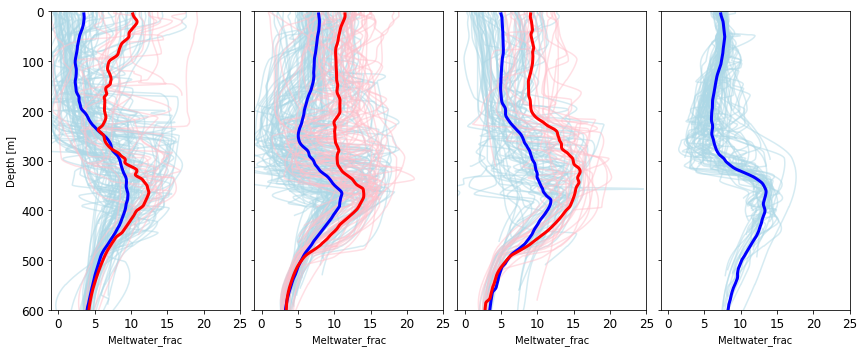

In [147]:
# need to set index to CT to plot CT
may19c.reset_index(inplace=True)
may19w.reset_index(inplace=True)
may19c.set_index('Meltwater_frac', inplace=True)
may19w.set_index('Meltwater_frac', inplace=True)

june19c.reset_index(inplace=True)
june19w.reset_index(inplace=True)
june19c.set_index('Meltwater_frac', inplace=True)
june19w.set_index('Meltwater_frac', inplace=True)

july19c.reset_index(inplace=True)
july19w.reset_index(inplace=True)
july19c.set_index('Meltwater_frac', inplace=True)
july19w.set_index('Meltwater_frac', inplace=True)

aug19c.reset_index(inplace=True)
aug19w.reset_index(inplace=True)
aug19c.set_index('Meltwater_frac', inplace=True)
aug19w.set_index('Meltwater_frac', inplace=True)

# plot
plt.figure(figsize=(12,5))
plt.rcParams['axes.facecolor']='w'
# # CT
plt.subplot(141)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
may19c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
may19w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_may19cmelt, may19c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_may19wmelt, may19w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)

plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
#
plt.subplot(142)
plt.xticks(fontsize=12)
june19c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
june19w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_june19cmelt, june19c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_june19wmelt, june19w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  
#
plt.subplot(143)
plt.xticks(fontsize=12)
july19c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
july19w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_july19cmelt, july19c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_july19wmelt, july19w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  
#
plt.subplot(144)
plt.xticks(fontsize=12)
aug19c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
aug19w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_aug19cmelt, aug19c_test.z_rounded['mean'], c='b',linewidth=3, label = 'mean cool')
plt.plot(smooth_aug19wmelt, aug19w_test.z_rounded['mean'], c='r',linewidth=3, label = 'mean warm')
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  

plt.tight_layout()

#plt.savefig('fig6_2019_updated.jpg', format='jpg', dpi=400)

## 2020

### 1. Read seal data (this time previsouly subsetted dataframe created at the end of fig.4 notebook)
This is just to save time, but we can also go through all the steps again similar to fig.4 and 5 scripts combined.

In [148]:
# read data
meltwater20array = pd.read_pickle('meltwater20array_file')
meltwater20array.head()

,CT,SA,z,Datetime,LATITUDE,LONGITUDE,Station,Meltwater_frac
0,-1.825675,34.004135,0.000000,2020-05-02 04:50:00.000009599,-74.507073,-102.514465,ct153-Akira-19_prof_corrected,17.338456
1,-1.825691,34.004113,0.989634,2020-05-02 04:50:00.000009599,-74.507073,-102.514465,ct153-Akira-19_prof_corrected,17.339920
2,-1.825708,34.004091,1.979263,2020-05-02 04:50:00.000009599,-74.507073,-102.514465,ct153-Akira-19_prof_corrected,17.341382
3,-1.825724,34.004069,2.968888,2020-05-02 04:50:00.000009599,-74.507073,-102.514465,ct153-Akira-19_prof_corrected,17.342845
4,-1.825740,34.004026,3.958508,2020-05-02 04:50:00.000009599,-74.507073,-102.514465,ct153-Akira-19_prof_corrected,17.345953


### 2. Partition by month

In [149]:
meltmay20 = meltwater20array[(meltwater20array['Datetime']>='2020-05-01') & (meltwater20array['Datetime']<'2020-06-1')] 
meltjune20 = meltwater20array[(meltwater20array['Datetime']>='2020-06-01') & (meltwater20array['Datetime']<'2020-07-1')] 
meltjuly20 = meltwater20array[(meltwater20array['Datetime']>='2020-07-01') & (meltwater20array['Datetime']<'2020-08-1')] 
meltaug20 = meltwater20array[(meltwater20array['Datetime']>'2020-08-01') & (meltwater20array['Datetime']<'2020-09-1')] 

### 3. Separate warm and cool/background profiles based on cutoff temp from step 2 and apply smoothing filter.
Lots of steps here, but essentially we are not doing much, just prepping the data for seperation of warm and cool dives for plotting.

In [150]:
# T cutoff thresh (defined in fig. 5 script)
seal20 = pd.read_pickle('seal20_file')

# define cool ("background") dives in dataframe within bounding box lat/lon
coolsurf = seal20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','Temperature [C]','CT','PD']].query('-74.9 < LATITUDE < -74 & -104.7 < LONGITUDE < -102 & 0.0 <= z <= 20')
coolsurfMJJA20 = coolsurf[(coolsurf['Datetime']>='2020-5-1') & (coolsurf['Datetime']<'2020-9-1')] # constrain winter months

# calculate temperature treshold at 3std > background surface mean
thresh2020 = coolsurfMJJA20['CT'].mean() + 3*coolsurfMJJA20['CT'].std()

# Cutoff T in deg C
print('2020 threshold:',thresh2020) #CT

2020 threshold: -1.7421517137000042


#### May 2020

In [151]:
# isolate may20 data
may20surf = meltmay20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
may20surf = may20surf.reset_index()

# round lat,lon
may20surf['LAT_rounded'] = round(may20surf.iloc[:,3],4)
may20surf['LONG_rounded'] = round(may20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
may20surf = may20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
may20surf = may20surf.reset_index()

# isolate warm profiles based on thresh
may20surfwarm = may20surf[may20surf.iloc[:,5] > thresh2020] 
may20surfcool = may20surf[may20surf.iloc[:,5] < thresh2020] 

# add rounded lat long to meltwater20array so that we have same header and vals
meltwater20array['LAT_rounded'] = round(meltwater20array.iloc[:,4],4)
meltwater20array['LONG_rounded'] = round(meltwater20array.iloc[:,5],4)
#seal20.head()

# isolate warm profiles w entire depth information - replace seal20 w meltwater20array b/c this one has meltwater in it
may20w = meltwater20array[meltwater20array['LAT_rounded'].isin(may20surfwarm['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(may20surfwarm['LONG_rounded'])]
may20c = meltwater20array[meltwater20array['LAT_rounded'].isin(may20surfcool['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(may20surfcool['LONG_rounded'])]
#may20w.count()

# probs need to round z first: warm
may20w['z_rounded'] = round(may20w.iloc[:,2])
may20w.head()
may20w_test = may20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
may20c['z_rounded'] = round(may20c.iloc[:,2])
may20c.head()
may20c_test = may20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_may20c = may20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may20w = may20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# SA
smooth_may20cSA = may20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may20wSA = may20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
# Melt
smooth_may20cmelt = may20c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_may20wmelt = may20w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/194419118.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may20w['z_rounded'] = round(may20w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/194419118.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  may20c['z_rounded'] = round(may20c.iloc[:,2])


#### June 2020

In [152]:
# isolate may20 data
june20surf = meltjune20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
june20surf = june20surf.reset_index()

# round lat,lon
june20surf['LAT_rounded'] = round(june20surf.iloc[:,3],4)
june20surf['LONG_rounded'] = round(june20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
june20surf = june20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
june20surf = june20surf.reset_index()

# isolate warm profiles based on thresh
june20surfwarm = june20surf[june20surf.iloc[:,5] > thresh2020] 
june20surfcool = june20surf[june20surf.iloc[:,5] < thresh2020] 

# add rounded lat long to meltwater20array so that we have same header and vals
meltwater20array['LAT_rounded'] = round(meltwater20array.iloc[:,4],4)
meltwater20array['LONG_rounded'] = round(meltwater20array.iloc[:,5],4)

# isolate warm profiles w entire depth information - replace seal20 w meltwater20array b/c this one has meltwater in it
june20w = meltwater20array[meltwater20array['LAT_rounded'].isin(june20surfwarm['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(june20surfwarm['LONG_rounded'])]
june20c = meltwater20array[meltwater20array['LAT_rounded'].isin(june20surfcool['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(june20surfcool['LONG_rounded'])]

# probs need to round z first: warm
june20w['z_rounded'] = round(june20w.iloc[:,2])
june20w_test = june20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
june20c['z_rounded'] = round(june20c.iloc[:,2])
june20c_test = june20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_june20c = june20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june20w = june20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_june20cSA = june20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june20wSA = june20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_june20cmelt = june20c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_june20wmelt = june20w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/1907469577.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june20w['z_rounded'] = round(june20w.iloc[:,2])
/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/1907469577.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june20c['z_rounded'] = round(june20c.iloc[:,2])


#### July 2020

In [153]:
# isolate jul20 data
july20surf = meltjuly20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
july20surf = july20surf.reset_index()

# round lat,lon
july20surf['LAT_rounded'] = round(july20surf.iloc[:,3],4)
july20surf['LONG_rounded'] = round(july20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
july20surf = july20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
july20surf = july20surf.reset_index()

# isolate warm profiles based on thresh
july20surfwarm = july20surf[july20surf.iloc[:,5] > thresh2020] 
july20surfcool = july20surf[july20surf.iloc[:,5] < thresh2020] 

# add rounded lat long to meltwater20array so that we have same header and vals
meltwater20array['LAT_rounded'] = round(meltwater20array.iloc[:,4],4)
meltwater20array['LONG_rounded'] = round(meltwater20array.iloc[:,5],4)

# isolate warm profiles w entire depth information - replace seal20 w meltwater20array b/c this one has meltwater in it
july20w = meltwater20array[meltwater20array['LAT_rounded'].isin(july20surfwarm['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(july20surfwarm['LONG_rounded'])]
july20c = meltwater20array[meltwater20array['LAT_rounded'].isin(july20surfcool['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(july20surfcool['LONG_rounded'])]

# probs need to round z first: warm
july20w['z_rounded'] = round(july20w.iloc[:,2])
july20w_test = july20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
july20c['z_rounded'] = round(july20c.iloc[:,2])
july20c_test = july20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_july20c = july20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july20w = july20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_july20cSA = july20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july20wSA = july20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_july20cmelt = july20c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_july20wmelt = july20w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/1329248839.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  july20c['z_rounded'] = round(july20c.iloc[:,2])


#### August 2020

In [154]:
# isolate may20 data
aug20surf = meltaug20[['z','Datetime','LATITUDE', 'LONGITUDE','SA','CT','Meltwater_frac','Station']].query('-75.25 < LATITUDE < -74.5 & -104 < LONGITUDE < -100 & 0 <= z <= 20')
aug20surf = aug20surf.reset_index()

# round lat,lon
aug20surf['LAT_rounded'] = round(aug20surf.iloc[:,3],4)
aug20surf['LONG_rounded'] = round(aug20surf.iloc[:,4],4)

# Groubpy (on rounded cols)
aug20surf = aug20surf.groupby(['LAT_rounded','LONG_rounded'],as_index=False).agg({'z' : ['count','mean'],'CT': 'mean', 'SA': 'mean','Meltwater_frac':'mean'})
aug20surf = aug20surf.reset_index()

# isolate warm profiles based on thresh
aug20surfwarm = aug20surf[aug20surf.iloc[:,5] > thresh2020] 
aug20surfcool = aug20surf[aug20surf.iloc[:,5] < thresh2020] 

# add rounded lat long to meltwater20array so that we have same header and vals
meltwater20array['LAT_rounded'] = round(meltwater20array.iloc[:,4],4)
meltwater20array['LONG_rounded'] = round(meltwater20array.iloc[:,5],4)
#seal20.head()

# isolate warm profiles w entire depth information - replace seal20 w meltwater20array b/c this one has meltwater in it
aug20w = meltwater20array[meltwater20array['LAT_rounded'].isin(aug20surfwarm['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(aug20surfwarm['LONG_rounded'])]
aug20c = meltwater20array[meltwater20array['LAT_rounded'].isin(aug20surfcool['LAT_rounded']) & meltwater20array['LONG_rounded'].isin(aug20surfcool['LONG_rounded'])]
#aug20w.count()

# probs need to round z first: warm
aug20w['z_rounded'] = round(aug20w.iloc[:,2])
aug20w.head()
aug20w_test = aug20w.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# probs need to round z first: cool
aug20c['z_rounded'] = round(aug20c.iloc[:,2])
aug20c.head()
aug20c_test = aug20c.groupby(['z_rounded'],as_index=False).agg({'z_rounded' : 'mean','CT': ['mean','std','sem'], 'SA': 'mean','Meltwater_frac':'mean'})

# # apply Gaussian filter before plotting (smoothing)
# CT
smooth_aug20c = aug20c_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug20w = aug20w_test.CT['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# SA
smooth_aug20cSA = aug20c_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug20wSA = aug20w_test.SA['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

# Melt
smooth_aug20cmelt = aug20c_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)
smooth_aug20wmelt = aug20w_test.Meltwater_frac['mean'].rolling(window=10, win_type='gaussian',center=True).mean(std=3)

/var/folders/89/l74gfpqj40z09y2mj3f1sw6h0000gn/T/ipykernel_5693/323515679.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aug20c['z_rounded'] = round(aug20c.iloc[:,2])


### 5. Reset dataframe index and plot profiles!

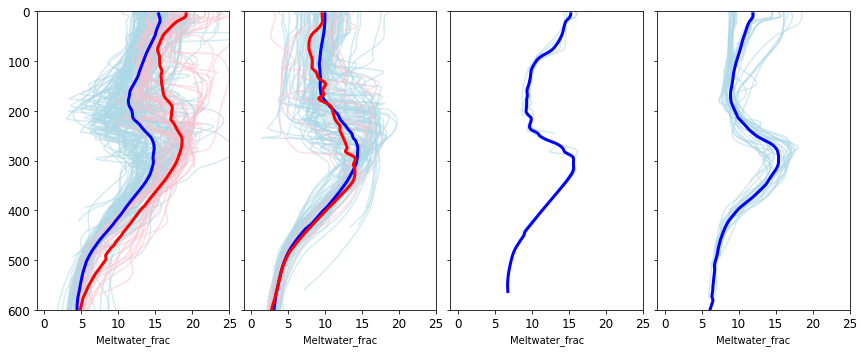

In [155]:
# need to set index to CT to plot CT
may20c.reset_index(inplace=True)
may20w.reset_index(inplace=True)
may20c.set_index('Meltwater_frac', inplace=True)
may20w.set_index('Meltwater_frac', inplace=True)

june20c.reset_index(inplace=True)
june20w.reset_index(inplace=True)
june20c.set_index('Meltwater_frac', inplace=True)
june20w.set_index('Meltwater_frac', inplace=True)

july20c.reset_index(inplace=True)
july20w.reset_index(inplace=True)
july20c.set_index('Meltwater_frac', inplace=True)
july20w.set_index('Meltwater_frac', inplace=True)

aug20c.reset_index(inplace=True)
aug20w.reset_index(inplace=True)
aug20c.set_index('Meltwater_frac', inplace=True)
aug20w.set_index('Meltwater_frac', inplace=True)

# plot
plt.figure(figsize=(12,5))
plt.rcParams['axes.facecolor']='w'
# # CT
plt.subplot(141)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
may20c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
may20w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_may20cmelt, may20c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_may20wmelt, may20w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)

#plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
#
plt.subplot(142)
plt.xticks(fontsize=12)
june20c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
june20w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_june20cmelt, june20c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_june20wmelt, june20w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  
#
plt.subplot(143)
plt.xticks(fontsize=12)
july20c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
july20w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_july20cmelt, july20c_test.z_rounded['mean'], c='b',linewidth=3)
plt.plot(smooth_july20wmelt, july20w_test.z_rounded['mean'], c='r',linewidth=3)
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  
#
plt.subplot(144)
plt.xticks(fontsize=12)
aug20c.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='lightblue',alpha=0.5)
aug20w.groupby(['LAT_rounded','LONG_rounded'])['z_rounded'].plot(color='pink',alpha=0.5)
plt.plot(smooth_aug20cmelt, aug20c_test.z_rounded['mean'], c='b',linewidth=3, label = 'mean cool')
plt.plot(smooth_aug20wmelt, aug20w_test.z_rounded['mean'], c='r',linewidth=3, label = 'mean warm')
plt.xlim(-1,25)
plt.ylim(0,600)
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False)  

plt.tight_layout()

#plt.savefig('fig6_2020_updated.jpg', format='jpg', dpi=400)

In [158]:
# check avg diff in melt between avg cool and warm
# 2014
np.abs(smooth_june14cmelt[5] - smooth_june14wmelt[5]),np.abs(smooth_july14cmelt[5] - smooth_july14wmelt[5]),np.abs(smooth_aug14cmelt[5] - smooth_aug14wmelt[5])

(8.20970160896686, 8.459466456672528, 8.366817636668358)

In [159]:
# check avg diff in melt between avg cool and warm
# 2019
np.abs(smooth_may19cmelt[5] - smooth_may19wmelt[5]),np.abs(smooth_june19cmelt[5] - smooth_june19wmelt[5]),np.abs(smooth_july19cmelt[5] - smooth_july19wmelt[5])

(6.726799709531303, 3.6307759719448773, 4.0697418887500465)

In [160]:
# check avg diff in melt between avg cool and warm
# 2020
np.abs(smooth_may20cmelt[5] - smooth_may20wmelt[5]),np.abs(smooth_june20cmelt[5] - smooth_june20wmelt[5])

(3.711905720036645, 0.37423796094221373)

### 6. I save all panels and format for submission in illustrator or powerpoint :)

Screenshot of Fig. 6 from Savidge et al., 2023:

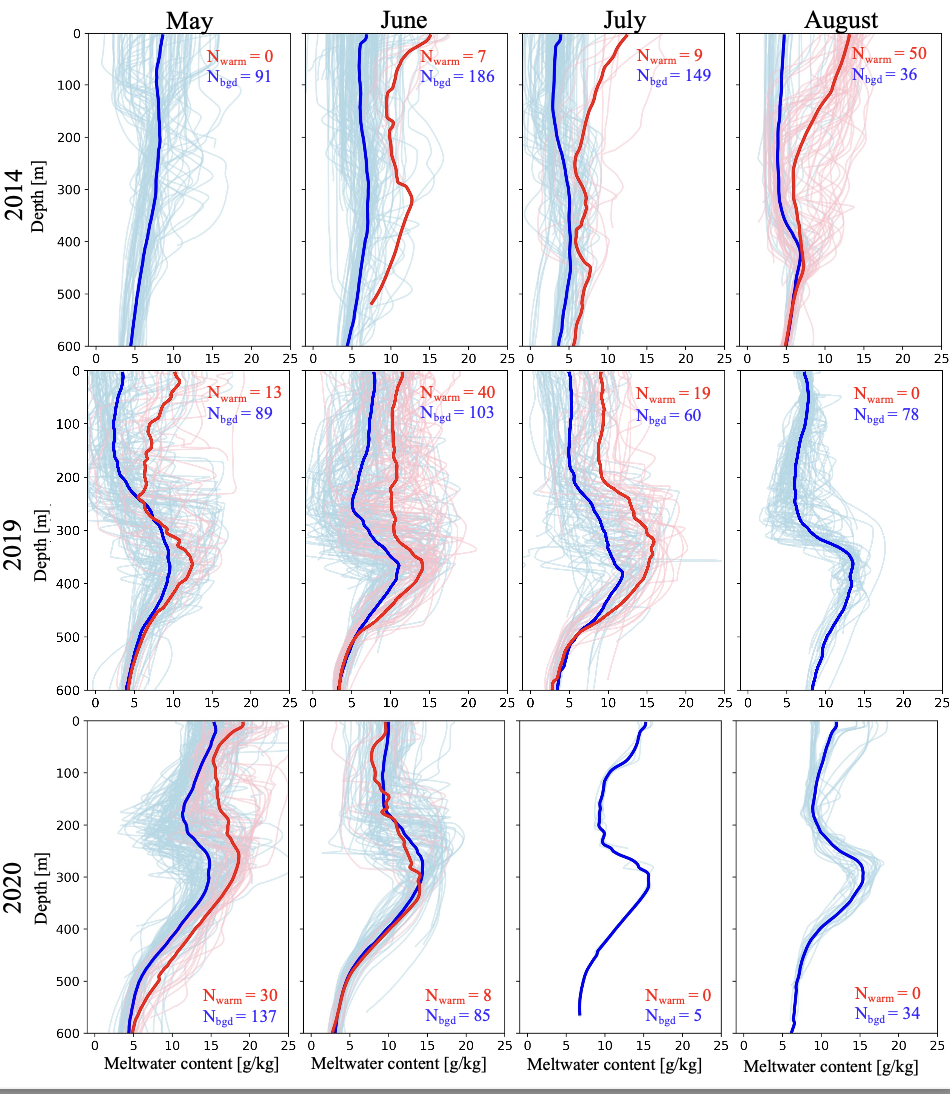

### ~ES